In [2]:
from petastorm import make_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis,skew
from scipy.signal import periodogram
from ecgdetectors import Detectors
import pywt
#import pandas as pd



In [53]:
##Read the dataset
path_formatted_glasgow = "/workspaces/maitrise/data/20220902_data_physio_formatted_merged/merged/dataParquet"
path_petastorm = f"file:///{path_formatted_glasgow}"
with make_reader(path_petastorm) as reader:
    for sample in reader:
        data = sample
        break


/home/vscode/.local/lib/python3.8/site-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  self._filesystem = pyarrow.localfs
/home/vscode/.local/lib/python3.8/site-packages/petastorm/etl/dataset_metadata.py:402: FutureWarning: Specifying the 'metadata_nthreads' argument is deprecated as of pyarrow 8.0.0, and the argument will be removed in a future version
  dataset = pq.ParquetDataset(path_or_paths, filesystem=fs, validate_schema=False, metadata_nthreads=10)
/home/vscode/.local/lib/python3.8/site-packages/petastorm/etl/dataset_metadata.py:362: FutureWarning: 'ParquetDataset.common_metadata' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version.
  if not dataset.common_metadata:
/home/vscode/.local/lib/python3.8/site-packages/petastorm/etl/dataset_metadata.py:368: FutureWarning: 'ParquetDataset.common_metadata' attribute is deprecated as of pyarrow 5.0.0 and will be 

In [54]:
print(data)

ECGSchema_view(noun_id=b'HR07175', signal_names=array([b'I', b'II', b'III', b'aVR', b'aVL', b'aVF', b'V1', b'V2', b'V3',
       b'V4', b'V5', b'V6'], dtype='|S3'), signal=array([[-0.225, -0.125,  0.1  , ..., -0.25 , -0.2  , -0.15 ],
       [-0.225, -0.125,  0.1  , ..., -0.25 , -0.2  , -0.15 ],
       [-0.225, -0.125,  0.1  , ..., -0.25 , -0.2  , -0.15 ],
       ...,
       [ 0.05 , -0.225, -0.275, ...,  0.175, -0.25 , -0.275],
       [ 0.05 , -0.225, -0.275, ...,  0.175, -0.25 , -0.275],
       [ 0.05 , -0.225, -0.275, ...,  0.175, -0.25 , -0.275]],
      dtype=float32), diagnostics=array([ 39732003, 164865005, 164951009, 426783006]), score_classes=array([ 39732003, 426783006]), signal_length=5000, sampling_frequency=500, age=44, sex=b'Male')


In [55]:
ECG_signal = data.signal
ECG_lead = data.signal_names
dico_ECG = {}
for i,j in zip(ECG_lead,range(12)):
    
     dico_ECG[i] = ECG_signal[:,j]


for lead I : 
Kurtosis =  13.357382314515814  and Skewness =  3.1652936983127686
Kurtosis =  19.36716562668349  and Skewness =  3.6599794158471606
Kurtosis =  11.745705368566595  and Skewness =  2.8397159515057218
Kurtosis =  18.028228342557416  and Skewness =  3.4384378389823076
Kurtosis =  13.311429118779607  and Skewness =  3.1449183719089855


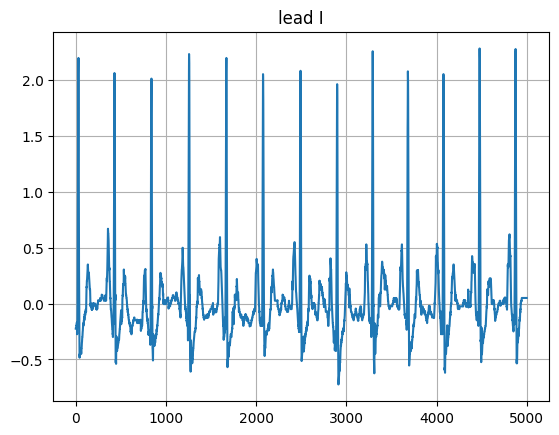

for lead II : 
Kurtosis =  5.672093265510098  and Skewness =  0.9547366583154194
Kurtosis =  6.02556607764955  and Skewness =  0.7449613150210808
Kurtosis =  3.999718211978883  and Skewness =  0.6901758736513888
Kurtosis =  6.8334565215385545  and Skewness =  1.1811827467083142
Kurtosis =  4.279476553157581  and Skewness =  0.8801782283073799


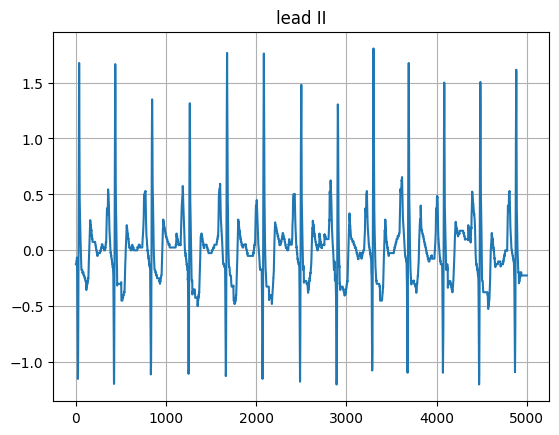

for lead III : 
Kurtosis =  9.303742090200316  and Skewness =  -2.0323242906720353
Kurtosis =  16.95431158190538  and Skewness =  -2.984545926107202
Kurtosis =  10.4463354747117  and Skewness =  -2.241989836585803
Kurtosis =  12.366897546343317  and Skewness =  -2.069580676866516
Kurtosis =  10.583388657970406  and Skewness =  -2.300657945262265


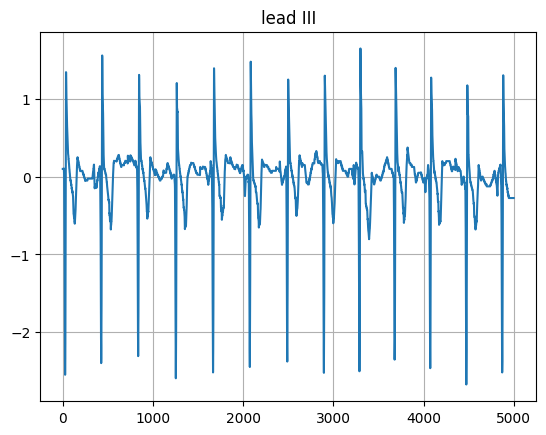

for lead aVR : 
Kurtosis =  8.114064234065602  and Skewness =  -2.3657635840637314
Kurtosis =  9.320390155857623  and Skewness =  -2.320806632425661
Kurtosis =  5.206456360158862  and Skewness =  -1.747341602079934
Kurtosis =  9.592480077082321  and Skewness =  -2.468734371195564
Kurtosis =  6.515755710534762  and Skewness =  -2.1349196402449406


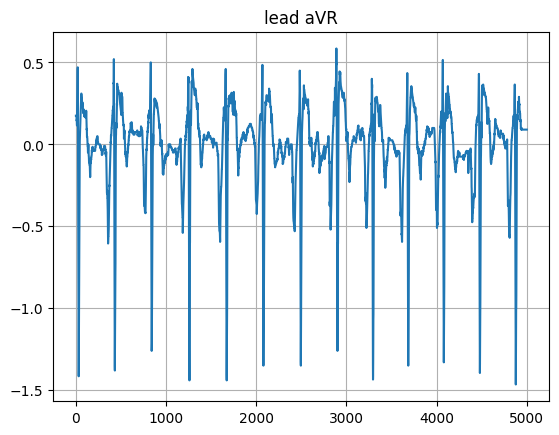

for lead aVL : 
Kurtosis =  12.151208023360477  and Skewness =  2.890960944835825
Kurtosis =  21.524338780849217  and Skewness =  3.850694192086642
Kurtosis =  13.142935419397517  and Skewness =  2.995951187500004
Kurtosis =  16.911774368768445  and Skewness =  3.1571627238484266
Kurtosis =  13.78166456514915  and Skewness =  3.1182353383775037


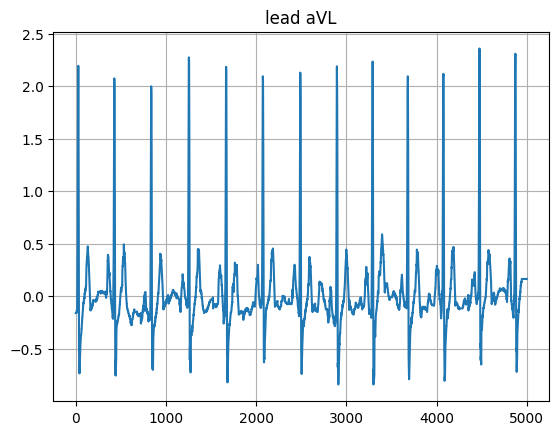

for lead aVF : 
Kurtosis =  6.925191409045629  and Skewness =  -0.7272338175140781
Kurtosis =  10.30761332169015  and Skewness =  -1.3131817590418207
Kurtosis =  6.773417747993852  and Skewness =  -0.8728638603849818
Kurtosis =  8.687632675438314  and Skewness =  -0.5328426961727388
Kurtosis =  6.700539299565429  and Skewness =  -0.8769146747145427


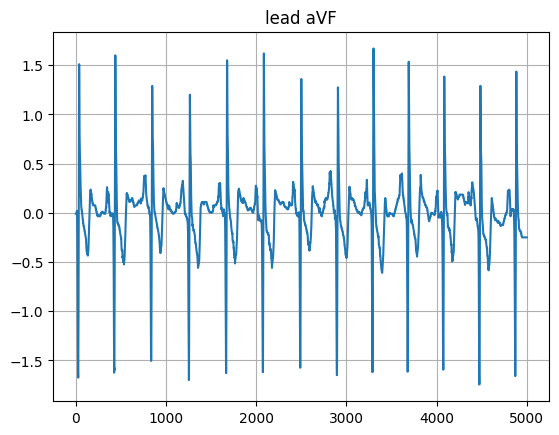

for lead V1 : 
Kurtosis =  11.586887725834329  and Skewness =  -2.9990674102410924
Kurtosis =  17.927961082504396  and Skewness =  -3.5322673650253815
Kurtosis =  11.411372578868377  and Skewness =  -2.93282876618791
Kurtosis =  17.09160649197837  and Skewness =  -3.3837942882678216
Kurtosis =  12.268153454543787  and Skewness =  -3.150325033394235


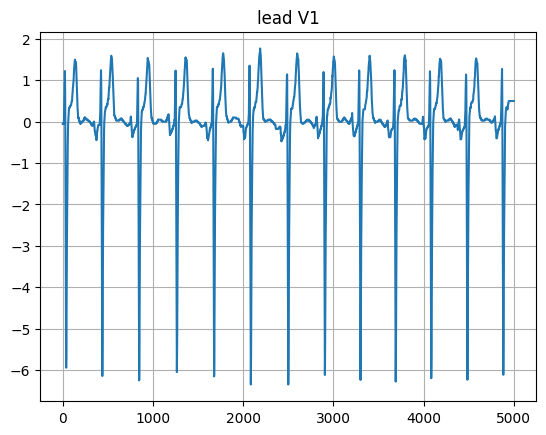

for lead V2 : 
Kurtosis =  7.354646037575245  and Skewness =  -1.9887259062132945
Kurtosis =  11.708672292869469  and Skewness =  -2.2233600768883983
Kurtosis =  8.015345551056525  and Skewness =  -2.087331086359087
Kurtosis =  10.351850931018935  and Skewness =  -2.027775343532202
Kurtosis =  8.771597378352583  and Skewness =  -2.297395211796156


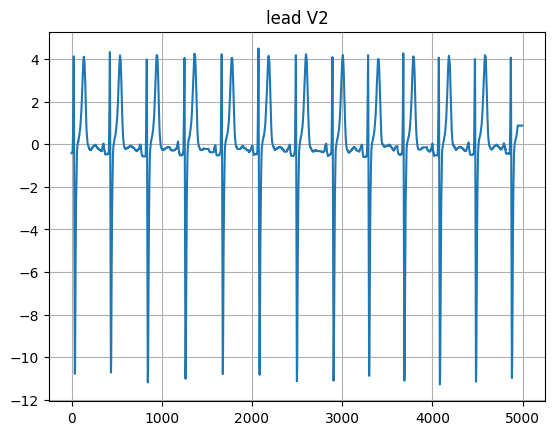

for lead V3 : 
Kurtosis =  8.664556159176653  and Skewness =  -2.329555091699683
Kurtosis =  14.112104847083476  and Skewness =  -2.7813960743258375
Kurtosis =  9.201256897218187  and Skewness =  -2.387990983930577
Kurtosis =  12.760002824617342  and Skewness =  -2.5629153519721646
Kurtosis =  9.896758898977128  and Skewness =  -2.5814203096741286


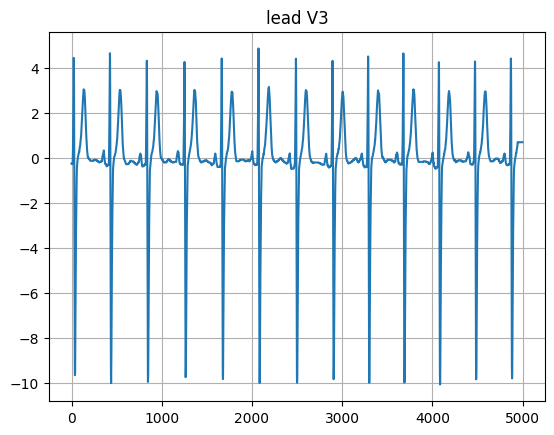

for lead V4 : 
Kurtosis =  8.916689794910258  and Skewness =  -1.211817256538688
Kurtosis =  14.270782331710091  and Skewness =  -1.4009865144143503
Kurtosis =  9.056804949692344  and Skewness =  -1.1117525709070561
Kurtosis =  13.702937664555588  and Skewness =  -1.4715276530892603
Kurtosis =  9.123231299712696  and Skewness =  -1.3456925133404798


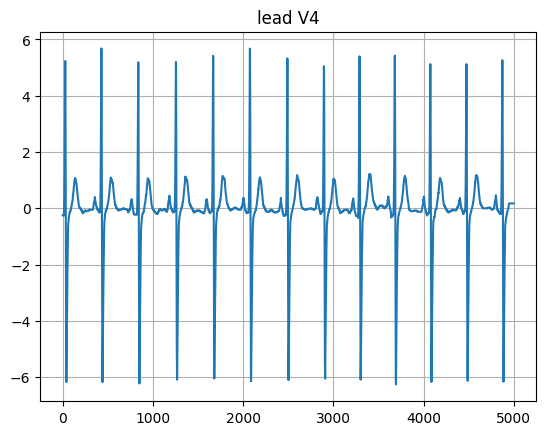

for lead V5 : 
Kurtosis =  16.170820234251515  and Skewness =  3.070735532548541
Kurtosis =  25.11811833347986  and Skewness =  3.6647188961241124
Kurtosis =  16.709717927418332  and Skewness =  3.2232702679172003
Kurtosis =  24.60763561896234  and Skewness =  3.566022311799845
Kurtosis =  15.701914097786279  and Skewness =  2.965914057885539


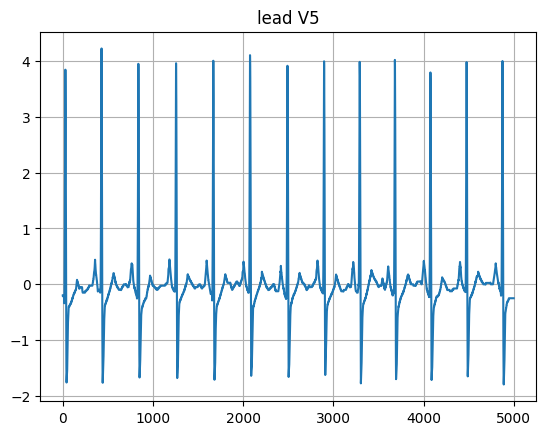

for lead V6 : 
Kurtosis =  14.449614759896054  and Skewness =  3.6435080600532066
Kurtosis =  22.035931236465462  and Skewness =  4.370286908346033
Kurtosis =  14.6440628176938  and Skewness =  3.699957011646451
Kurtosis =  22.435952292626887  and Skewness =  4.378629165527138
Kurtosis =  13.822590333256034  and Skewness =  3.5358251372185094


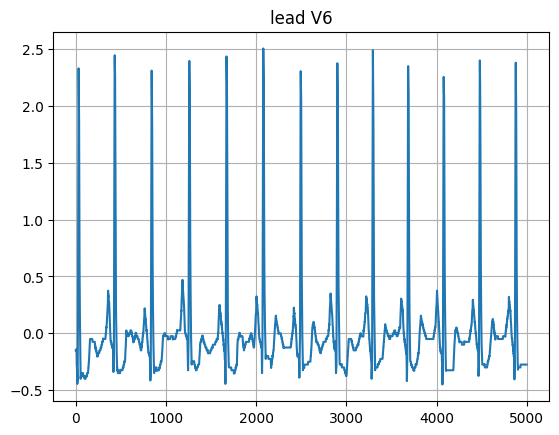

In [56]:
##Kurtosis SQI factor :
def kurtosis_SQI(signal):
    return kurtosis(signal)

##Skewness SQI factor:
def Skewness_SQI(signal):
    return skew(signal)

for i in ECG_lead:
    print(f"for lead {i.decode('utf8')} : ")
    for j in range(5):
        print("Kurtosis = ",kurtosis_SQI(dico_ECG[i][j*1000:(1000)*(j+1)]), " and Skewness = ", Skewness_SQI(dico_ECG[i][j*1000:(1000)*(j+1)]))
    plt.plot(dico_ECG[i])
    plt.grid()
    plt.title(f"lead {i.decode('utf8')}")
    plt.show()

In [ ]:
#SDR factor :

def SDR(signals,ECG_lead,fs = data.sampling_frequency):
    for i in ECG_lead:
        for j in range(5):
            f,PSD = periodogram(signals[i][j*1000:(1000)*(j+1)],fs)
            ECG_signal_PSD = np.sum(PSD[np.logical_and(f>5,f<14)])
            ECG_tot = np.sum(PSD[np.logical_and(f>5,f<50)])
            SDR_val = ECG_signal_PSD/ECG_tot
            print(f"for lead {i.decode('utf8')} between [{j*1000},{(j+1)*(1000)}]:",SDR_val)
        plt.plot(dico_ECG[i])
        plt.title(f"lead {i.decode('utf8')}")
        plt.show()
        #plt.semilogy(f, PSD)
        #plt.ylim([1e-7, 1e2])
        #plt.xlabel('frequency [Hz]')
        #plt.ylabel('PSD [V**2/Hz]')
        #plt.show()
        
SDR(dico_ECG,ECG_lead)       

In [ ]:
#Beats detector ECG
def QRS_detector(signal,lead,fs = data.sampling_frequency):
    detect = Detectors(fs)
    for i in lead:
        r_peaks = detect.swt_detector(signal[i])
        print(r_peaks)
        plt.plot(signal[i],marker = "o",markerfacecolor = "red",color = "b",markevery = r_peaks,label = "R-peaks detected")
        plt.legend()
        plt.title(f"R-peaks for lead {i.decode('utf-8')}")
        plt.show()

QRS_detector(dico_ECG,ECG_lead)

In [ ]:
##Wavelet decomposition

for i in ECG_lead:
    fig, ax = plt.subplots(figsize=(6,1))
    ax.set_title(f"Original signal for lead {i.decode('utf8')}")
    ax.plot(dico_ECG[i])
    plt.show() 
    data = dico_ECG[i]
    waveletname = 'db4'
 
    fig, axarr = plt.subplots(nrows=10, ncols=2, figsize=(10,10))
    for ii in range(10):
        (data, coeff_d) = pywt.dwt(data, waveletname)
        axarr[ii, 0].plot(data, 'r')
        axarr[ii, 1].plot(coeff_d, 'g')
        axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
        axarr[ii, 0].set_yticklabels([])
        if ii == 0:
            axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
            axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
        axarr[ii, 1].set_yticklabels([])
    plt.tight_layout()
    plt.show()  


In [57]:
### Try with another python method:
waveletname = 'db4'
level_w = 9
i = ECG_lead[1]

def Wavelet_coef(sig,name,lev):
    All_coeff = pywt.wavedec(sig,name,level = lev)

    CA_w = All_coeff[0]
    CD_w = All_coeff[1:len(All_coeff)]
    #fig, ax = plt.subplots(figsize=(6,1))
    #ax.set_title(f"approximation signal at level {lev} for lead {i.decode('utf8')}")
    #ax.plot(CA_w)
    #plt.show()

    #fig, axarr = plt.subplots(nrows=lev, ncols=1, figsize=(lev,lev))
    #for j in range(len(CD_w)):
        #axarr[j].plot(np.asarray(CD_w)[-(j+1)])
        #axarr[j].set_ylabel("Level {}".format(j + 1), fontsize=14, rotation=90)
        #axarr[j].set_yticklabels([])
        #if j ==0:
            #axarr[j].set_title("detail coefficients", fontsize=14)
    
    #plt.tight_layout()
    #plt.show()
    return CA_w,CD_w  


/tmp/ipykernel_401/2777331786.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p = np.append(p,Energy_L2(np.asarray(CD_w)[-(CD+1)])/Etot)
/tmp/ipykernel_401/2777331786.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  POWER = np.append(POWER,np.append(p,Energy_L2(np.asarray(CD_w)[-(CD+1)])))


0.004334963771161283


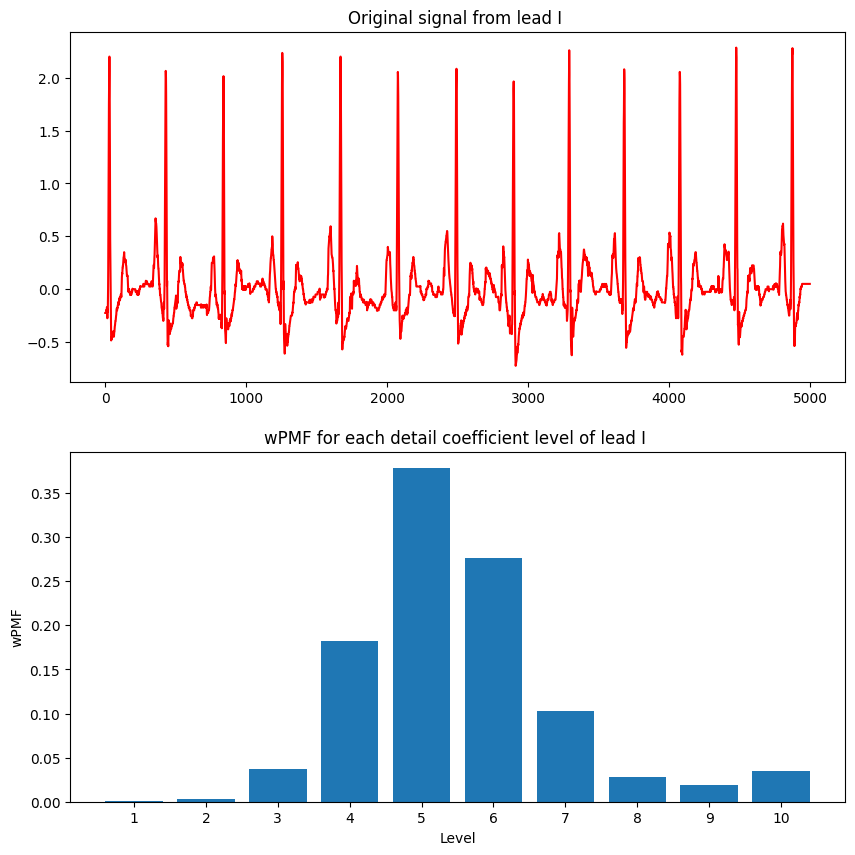

0.006836830807485172


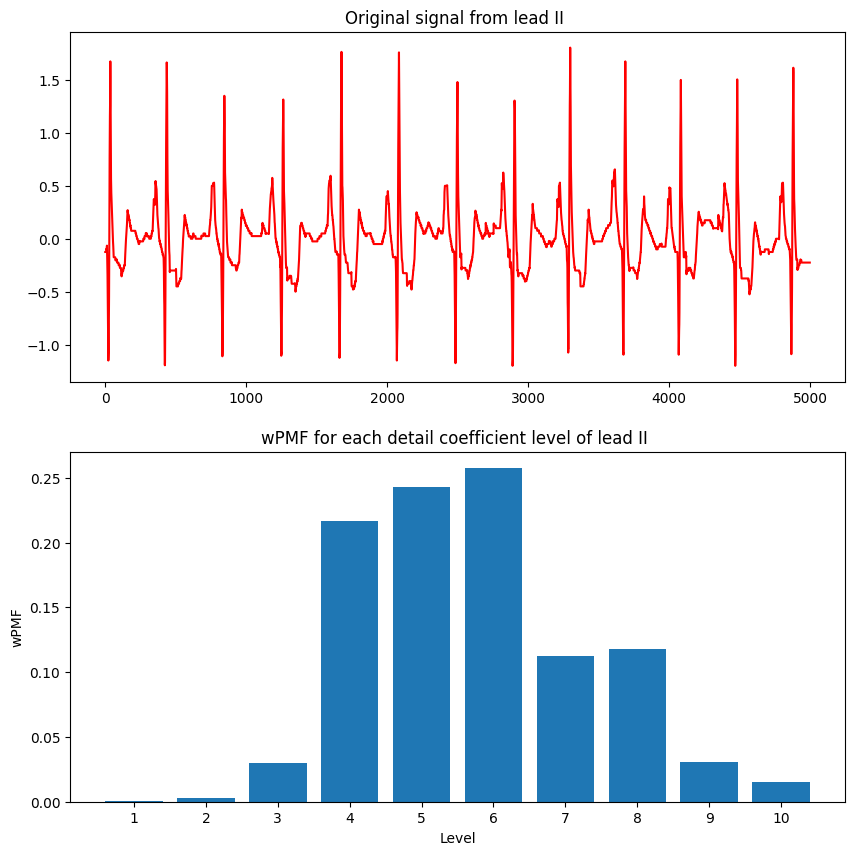

0.006892802587539175


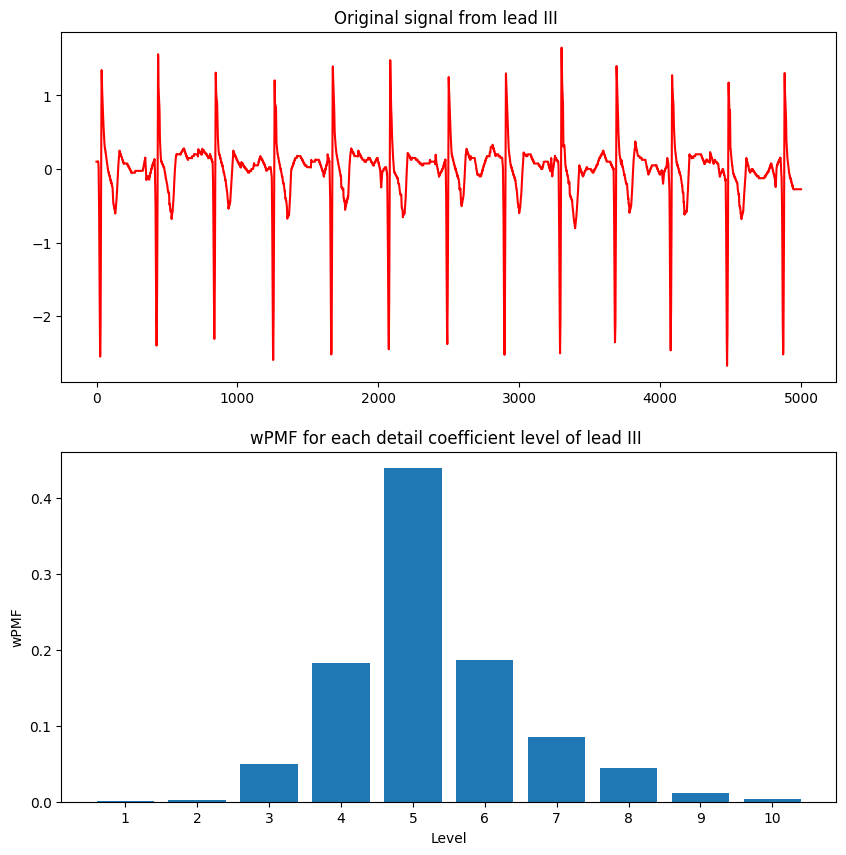

0.006375680504697497


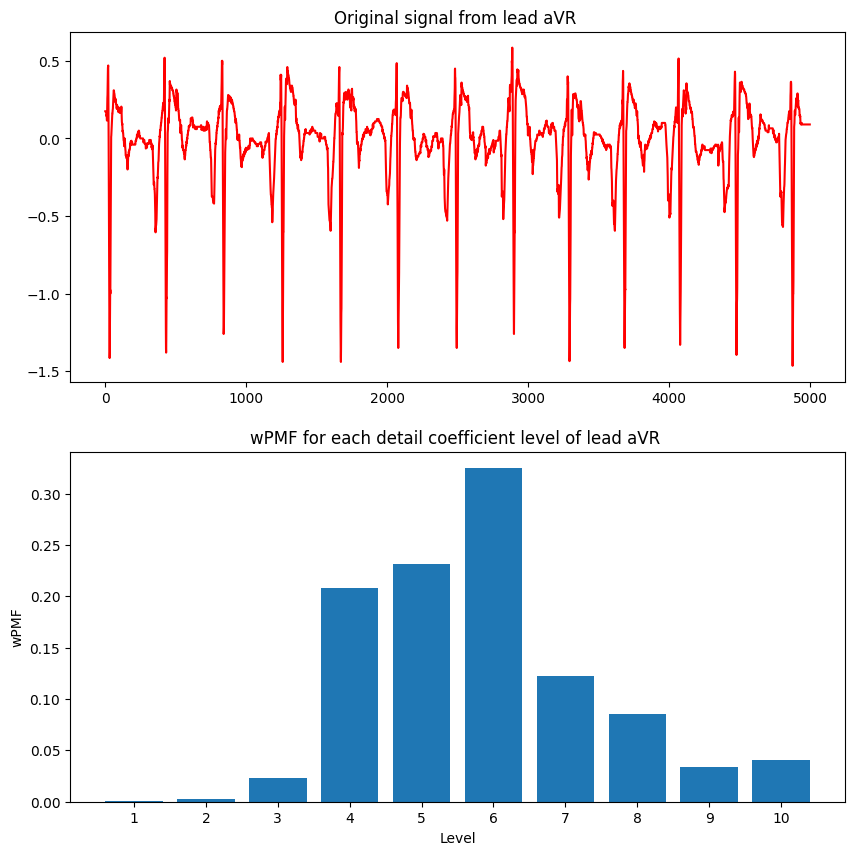

0.006561022245314527


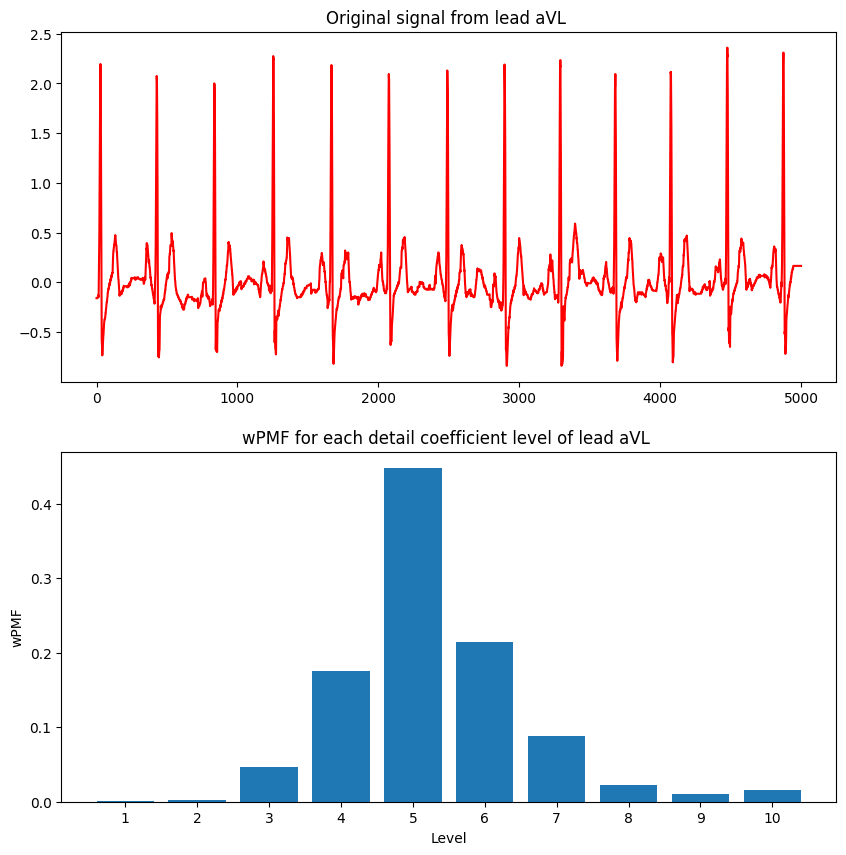

0.01046109980210282


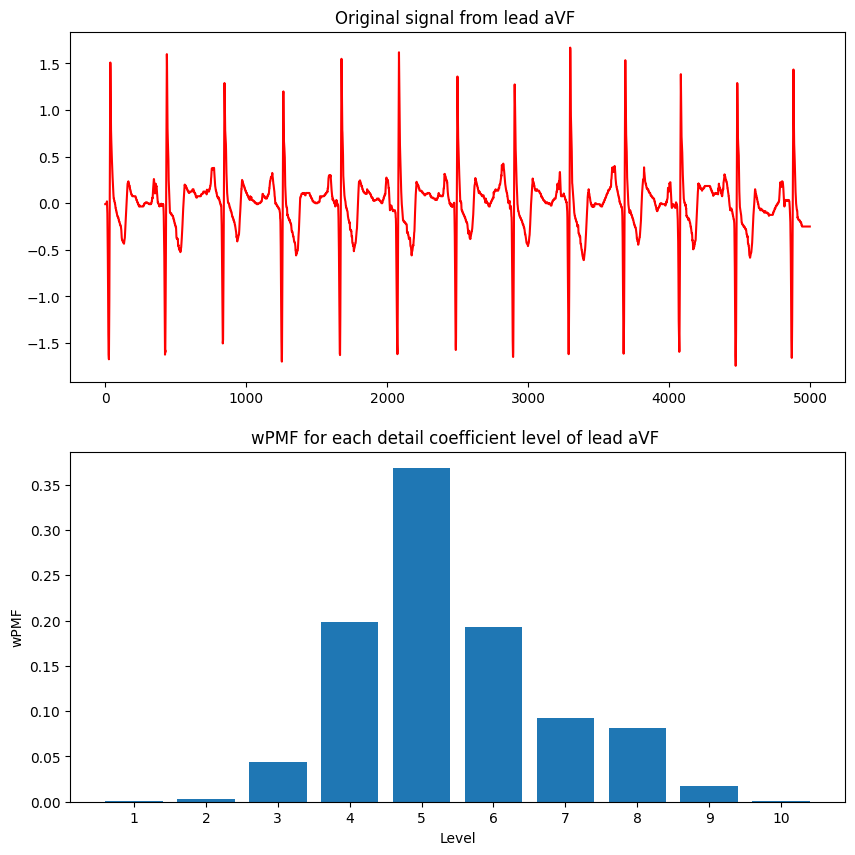

0.0015428557857337774


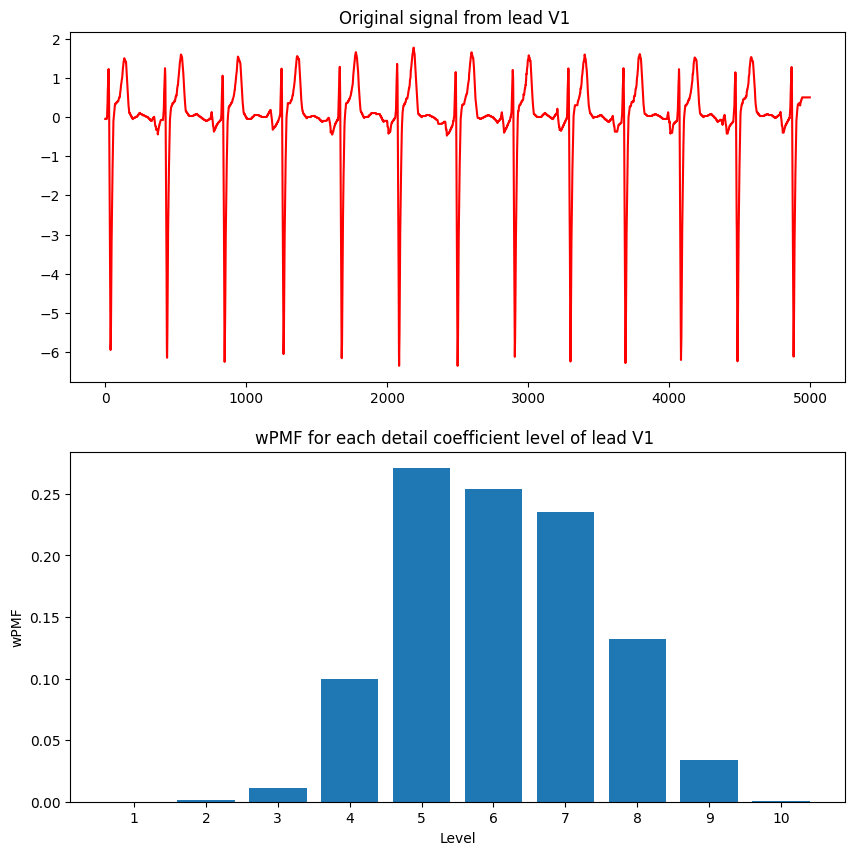

0.0005869292976552278


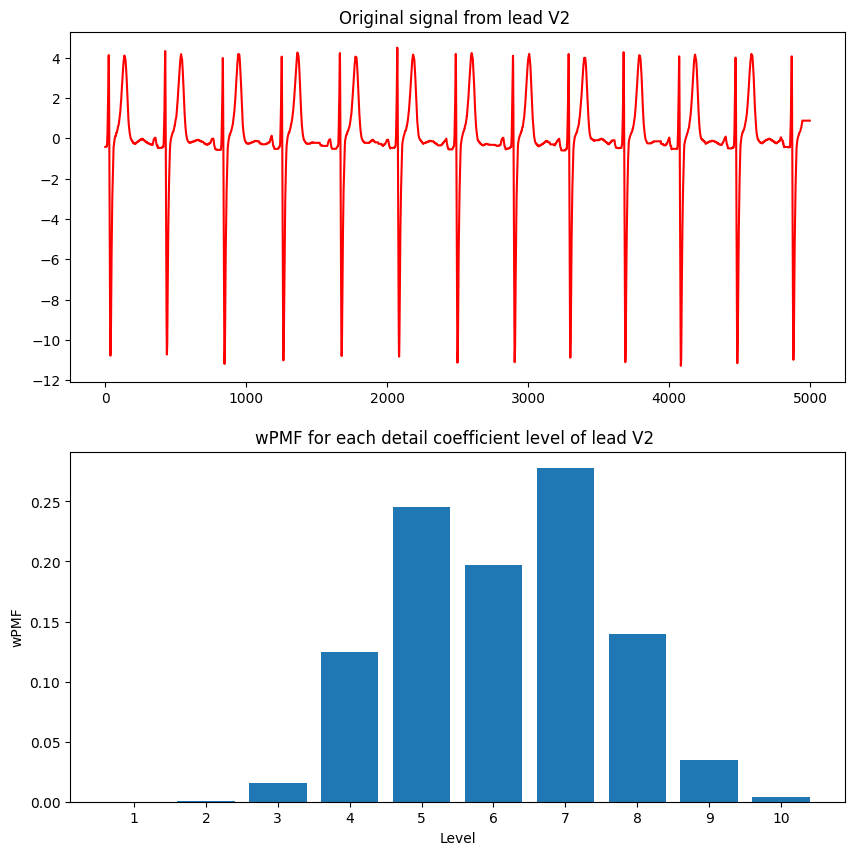

0.0005288663144396283


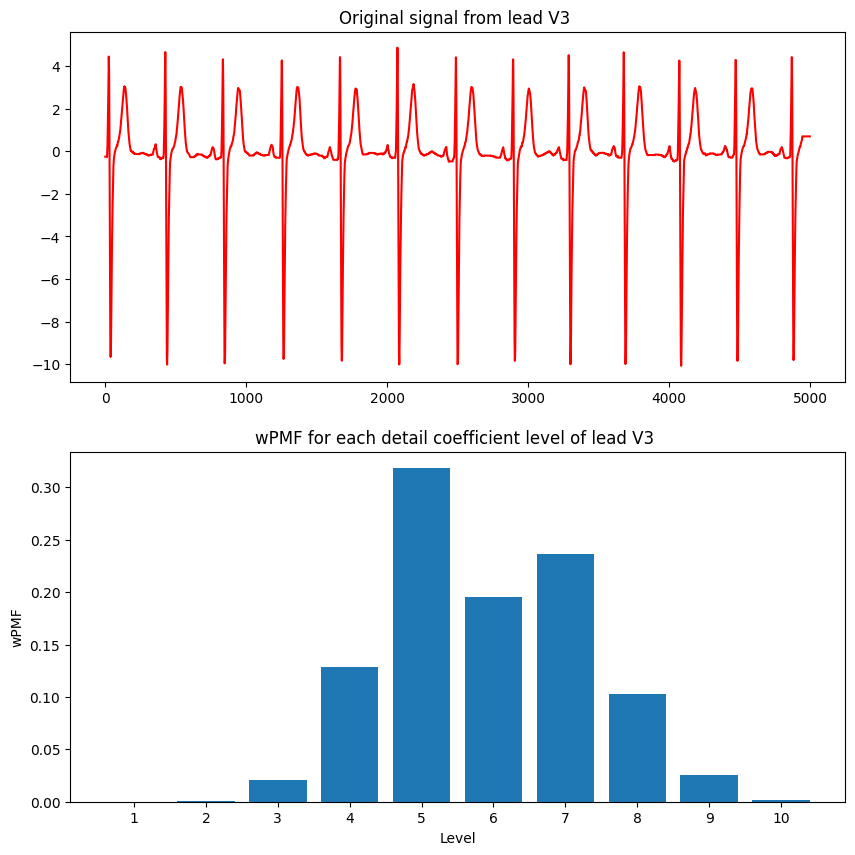

0.0014641370846187112


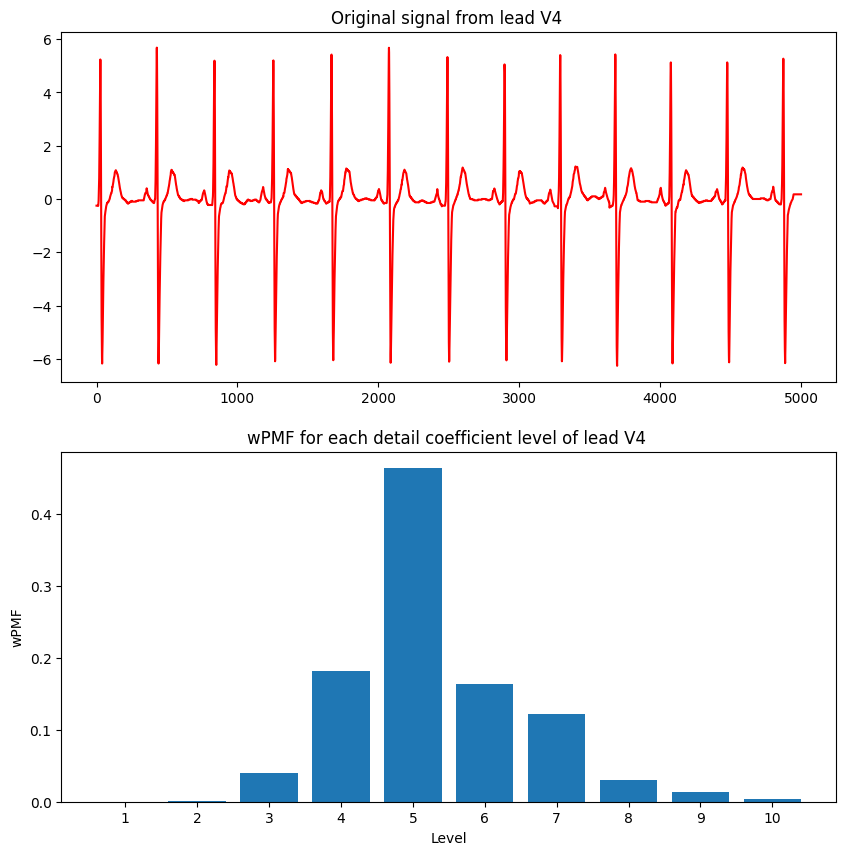

0.002928448186293901


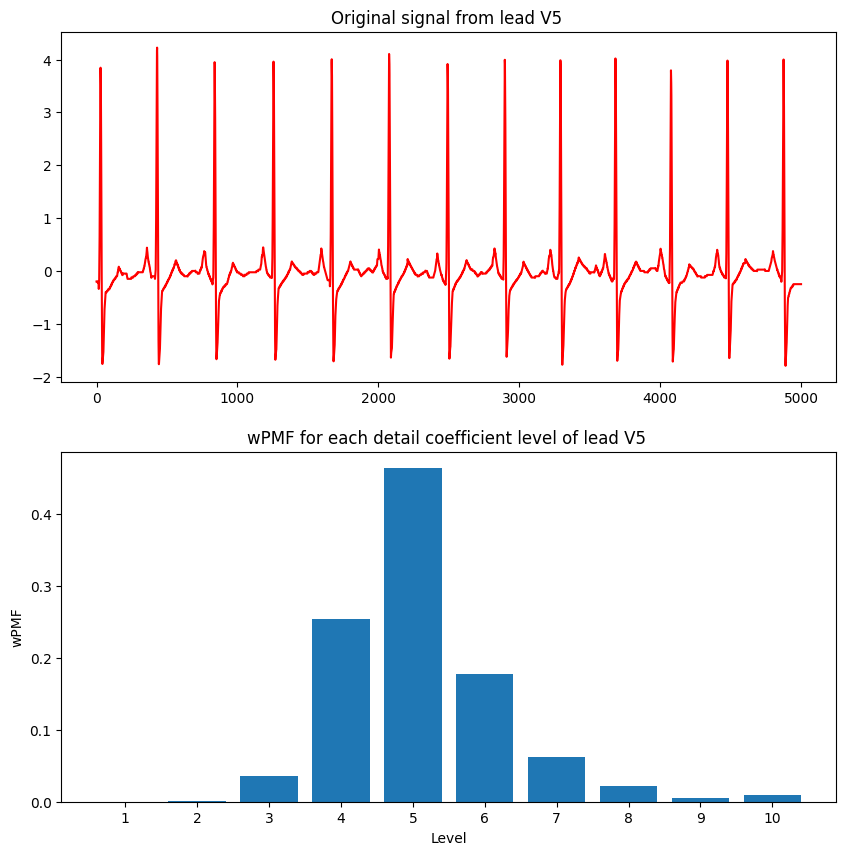

0.004093766564989489


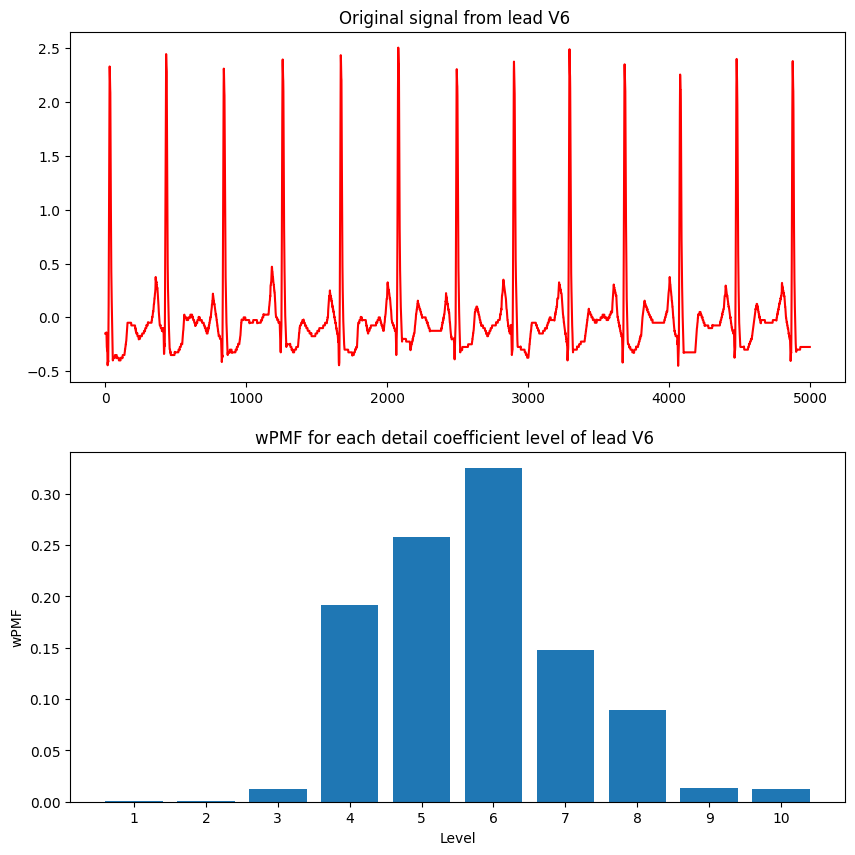

In [61]:
##Calcuation of the wPMF (wavelet probability  mass function):

def Energy_L2(coeff):
    return np.sum(np.abs(coeff)**2)

for i in ECG_lead:
    CA_w,CD_w = Wavelet_coef(dico_ECG[i],waveletname,level_w)
    Etot = Energy_L2(dico_ECG[i])
    p = np.array([])
    POWER = np.array([])
    for CD in range(level_w):
        p = np.append(p,Energy_L2(np.asarray(CD_w)[-(CD+1)])/Etot)
        POWER = np.append(POWER,np.append(p,Energy_L2(np.asarray(CD_w)[-(CD+1)])))
    p = np.append(p,Energy_L2(np.asarray(CA_w)[0])/Etot)
    POWER = np.append(POWER,np.append(p,Energy_L2(np.asarray(CA_w)[-(CD+1)])))
    SQI_proposal = (np.sum(POWER[3:4]))/(np.sum(POWER[0:2])+np.sum(POWER[5:level_w-1]))
    print(SQI_proposal)
    fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
    ax[0].set_title(f"Original signal from lead {i.decode('utf8')} ")
    ax[0].plot(dico_ECG[i],'r')
    ax[1].set_title(f"wPMF for each detail coefficient level of lead {i.decode('utf8')} ")
    ax[1].bar(range(1,level_w+2),p)
    plt.xticks(range(1,level_w+2),range(1,level_w+2))
    ax[1].set_xlabel("Level")
    ax[1].set_ylabel("wPMF")
    plt.show()

    
    
